## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.WW

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.
#%%

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from cv import *

In [49]:
test = VGGFeatures()

In [50]:
test.forward(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 512, 7, 7])

In [51]:
content2views = ContentToViews()


In [52]:
content2views.forward(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 1])

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
device

device(type='cuda')

In [55]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=25, train_loss_list:list =[], test_loss_list:list =[], device=device):
    model.to(device)
    model.train()
    print('Starting Training')

    curr_best_loss = torch.tensor(float('inf'))
    for epoch in range(epochs):
        start_time = time.time()
        print(f'Epoch [{epoch + 1} / {epochs}]')
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print(f'Batch [{i + 1} / {len(train_loader)}]', end='\r')
        
        train_loss_list.append(running_loss /  len(train_loader))
        print(f"Training loss: {running_loss / len(train_loader):.4f}")
        model.eval()
        with torch.no_grad():
            test_loss = 0.0
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            test_loss_list.append(running_loss / len(train_loader))
            print(f'Test loss: {test_loss / len(test_loader):.4f}')
            if test_loss < curr_best_loss:
                curr_best_loss = test_loss
                torch.save(model.state_dict(), 'best_model.pt')
        model.train()
        end_time = time.time()
        print(f'Took: {end_time - start_time:.2f}s, est time: {(end_time - start_time) * (epochs - epoch - 1):.2f}s')
    print('Finished Training')

In [56]:
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import csv

In [57]:
csv_content = csv.reader(open("data/USvideos.csv", 'r'))
next(csv_content).index("views")

7

In [58]:
import pandas as pd
import numpy as np

In [59]:
import os

class ContentToViewsDataset(Dataset):
    """
    Data loader for content to views dataset
    The data is a jpg file
    The label is a scalar value
    
    """

    def __init__(self, 
                 image_dir:str, 
                 csv_file:str,
                 cap = -1,
                views_name:str = "views",  
                id_name:str = "video_id",
                transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if cap < 0:
            cap = len(os.listdir(image_dir))

        self.image_dir = image_dir
        self.files = os.listdir(image_dir)[:cap]
        self.transform = transform

        df = pd.read_csv(csv_file)
        self.views = df.set_index(id_name)[views_name].to_dict()
        self.titles = df.set_index(id_name)["title"].to_dict()
        
        

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        """
        The output should be a scalar value,
        """
        img_name = os.path.join(self.image_dir, self.files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)

        video_id = self.files[idx][:-4]
        view_count = self.views[video_id]
        # title = self.titles[video_id]
        if  view_count == "":
            view_count = 0
        # if title == "":
        #         print("No title")
        #         title = " "

        # change to tensor
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32)
        view_count = torch.tensor([
            np.log(int(view_count))
            ], dtype=torch.float32)
        
        return image_tensor, view_count


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


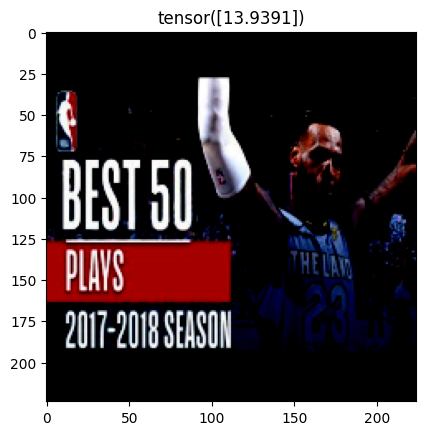

In [60]:
import matplotlib.pyplot as plt
# The raw image is 480 × 360 x3
# We will resize it to 224 × 224 x 3
# We will also normalize the image


dataset = ContentToViewsDataset('data/thumbnailUS', "data/USvideos.csv", 
                                transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))


# Show image and label
image, label = dataset[0]

image = image.numpy().transpose((1, 2, 0))

plt.imshow(image)
plt.title(label)
plt.show()

In [61]:
# The raw image is 480 × 360
# We will resize it to 224 × 224
# We will also normalize the image

dataset = ContentToViewsDataset('data/thumbnailUS', "data/USvideos.csv", 
                                cap=-1,
                                transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))

In [62]:
# split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [63]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=2)

In [65]:
def start_training(model, epochs=25, train_loss_list:list = [], test_loss_list:list=[]):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    train(model, optimizer, criterion, train_dataloader, test_dataloader, epochs=epochs, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

Starting Training
Epoch [1 / 2]
Training loss: 10.7657
Test loss: 3.1804
Took: 122.36s, est time: 122.36s
Epoch [2 / 2]
Training loss: 4.4867
Test loss: 5.2703
Took: 124.64s, est time: 0.00s
Finished Training


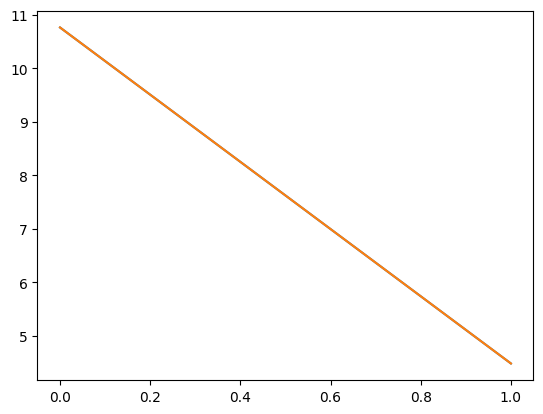

In [66]:
train_loss_list = []
test_loss_list = []

start_training(content2views, epochs=2 , train_loss_list=train_loss_list, test_loss_list=test_loss_list)

plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.show()

In [67]:
start_training(content2views, epochs=10, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

Starting Training
Epoch [1 / 10]
Training loss: 4.7239
Test loss: 3.4912
Took: 150.21s, est time: 1351.88s
Epoch [2 / 10]
Training loss: 3.9755
Test loss: 3.2888
Took: 123.22s, est time: 985.74s
Epoch [3 / 10]
Training loss: 3.6458
Test loss: 3.2949
Took: 119.56s, est time: 836.94s
Epoch [4 / 10]
Training loss: 3.2653
Test loss: 3.6496
Took: 119.51s, est time: 717.04s
Epoch [5 / 10]
Training loss: 2.7742
Test loss: 3.4147
Took: 119.45s, est time: 597.25s
Epoch [6 / 10]
Training loss: 2.2262
Test loss: 3.8996
Took: 144.98s, est time: 579.93s
Epoch [7 / 10]
Training loss: 1.8858
Test loss: 4.1188
Took: 153.85s, est time: 461.54s
Epoch [8 / 10]
Training loss: 1.6344
Test loss: 3.4149
Took: 157.81s, est time: 315.61s
Epoch [9 / 10]
Training loss: 1.5083
Test loss: 3.6237
Took: 121.04s, est time: 121.04s
Epoch [10 / 10]
Training loss: 1.4619
Test loss: 3.5322
Took: 159.62s, est time: 0.00s
Finished Training


In [78]:
start_training(content2views, epochs=10, train_loss_list=train_loss_list, test_loss_list=test_loss_list)

Starting Training
Epoch [1 / 10]
Training loss: 1.6196
Test loss: 3.3242
Took: 124.19s, est time: 1117.67s
Epoch [2 / 10]
Training loss: 1.5820
Test loss: 3.4044
Took: 129.32s, est time: 1034.54s
Epoch [3 / 10]
Training loss: 1.5085
Test loss: 3.8644
Took: 124.20s, est time: 869.37s
Epoch [4 / 10]
Training loss: 1.3730
Test loss: 3.2091
Took: 123.09s, est time: 738.52s
Epoch [5 / 10]
Training loss: 1.3289
Test loss: 3.2338
Took: 120.03s, est time: 600.13s
Epoch [6 / 10]
Training loss: 1.2802
Test loss: 3.1455
Took: 124.96s, est time: 499.83s
Epoch [7 / 10]
Training loss: 1.2471
Test loss: 3.2726
Took: 167.53s, est time: 502.60s
Epoch [8 / 10]
Training loss: 1.2138
Test loss: 4.4730
Took: 166.15s, est time: 332.30s
Epoch [9 / 10]
Training loss: 1.2478
Test loss: 3.2794
Took: 167.59s, est time: 167.59s
Epoch [10 / 10]
Training loss: 1.2435
Test loss: 3.1972
Took: 167.43s, est time: 0.00s
Finished Training


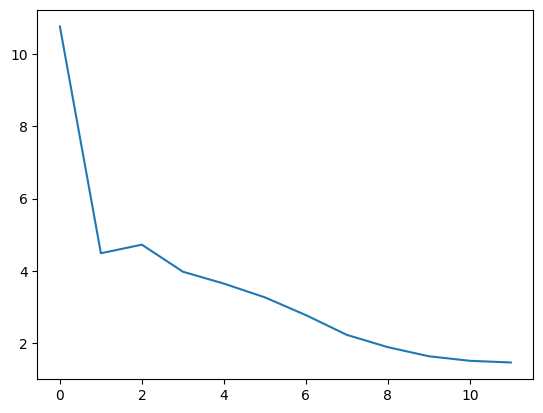

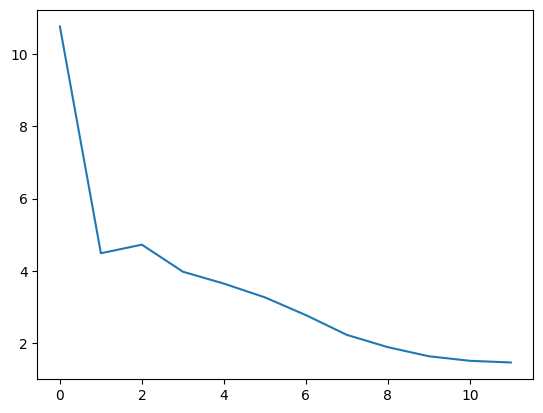

In [68]:
plt.plot(train_loss_list)
plt.show()
plt.plot(test_loss_list)
plt.show()

In [75]:
best_model = ContentToViews()
best_model.load_state_dict(torch.load("best_model.pt"))


torch.float32


In [76]:
images, views = [], []
for i in range(len(test_dataset)):
    image, view = test_dataset[i]
    images.append(image)
    views.append(view)

both = list(zip(images, views))

sorted_both = sorted(both, key=lambda x: x[1])

images, views = zip(*sorted_both)

# views

(tensor([7.0934]),
 tensor([7.1033]),
 tensor([7.2226]),
 tensor([7.2457]),
 tensor([7.2626]),
 tensor([7.4319]),
 tensor([7.6420]),
 tensor([7.7656]),
 tensor([7.9010]),
 tensor([7.9392]),
 tensor([7.9516]),
 tensor([8.0216]),
 tensor([8.0288]),
 tensor([8.0324]),
 tensor([8.0497]),
 tensor([8.0615]),
 tensor([8.1203]),
 tensor([8.1348]),
 tensor([8.1438]),
 tensor([8.1510]),
 tensor([8.2255]),
 tensor([8.2723]),
 tensor([8.3028]),
 tensor([8.3065]),
 tensor([8.3371]),
 tensor([8.3827]),
 tensor([8.3862]),
 tensor([8.4851]),
 tensor([8.5017]),
 tensor([8.5071]),
 tensor([8.5198]),
 tensor([8.6262]),
 tensor([8.6685]),
 tensor([8.6933]),
 tensor([8.7196]),
 tensor([8.7240]),
 tensor([8.7515]),
 tensor([8.7659]),
 tensor([8.7877]),
 tensor([8.9091]),
 tensor([8.9440]),
 tensor([8.9549]),
 tensor([8.9843]),
 tensor([9.0470]),
 tensor([9.0728]),
 tensor([9.1042]),
 tensor([9.2173]),
 tensor([9.2743]),
 tensor([9.3640]),
 tensor([9.3661]),
 tensor([9.3949]),
 tensor([9.4340]),
 tensor([9.4

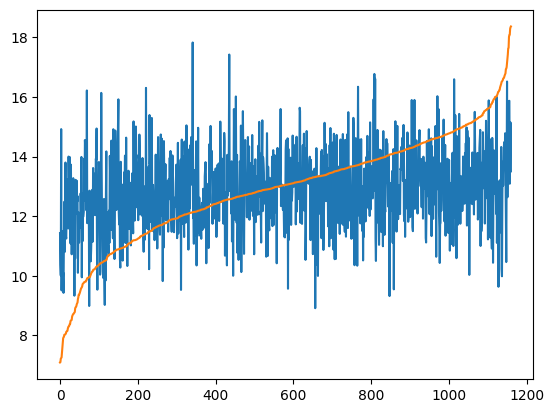

In [77]:
predict_views_counts = []
actual_views_counts = []

for i in range(len(images)):
    with torch.no_grad():
        image = images[i].to(device)
        predict_views_log = content2views.forward(image.unsqueeze(0)).cpu()
        predict_views = predict_views_log[0][0]
        actual_views = views[i][0]
        predict_views_counts.append(predict_views)
        actual_views_counts.append(actual_views)

plt.plot(predict_views_counts)
plt.plot(actual_views_counts)
plt.show()